In [1]:
from os import listdir

import xarray as xr
import numpy as np
from scipy.stats import linregress
import regionmask
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


import cartopy.crs as ccrs
import cartopy.feature as cfeature

import geopandas as gpd
from shapely.geometry import Point


import pandas as pd

import cop
import copv2

import pooch

In [2]:
scenarios = 'ssp126', 'ssp370'
scenario_labels = {'ssp126': 'SSP1-2.6',
                   'ssp370': 'SSP3-7.0'}
methods = ('choi', 'chow', 'ryu')


In [3]:
ds_dict = {}
for sce in scenarios: 
    ds_dict[sce] = xr.open_dataset(f'tasmax.acdays.{sce}.nc')
hist = xr.open_dataset('tasmax.acdays.1985-2014.nc')

In [4]:
c = copv2.COP()

Set point temperature is: 296.15K


In [5]:
# Create data arrays for each method for each time period
cop_da = {meth: {sce: c.getCOP(ds_dict[sce]['tasmax'].mean(dim='model'), method=meth) 
                 for sce in scenarios} 
          for meth in methods}
for meth in methods:
    cop_da[meth]['hist'] = c.getCOP(hist['t2m'], method=meth)


In [6]:
method_list = []

for meth in methods:
    scenario_list = []
    for sce in ['hist', 'ssp126', 'ssp370']:
        # Add new variable to turn into dimensions
        cop_da[meth][sce] = cop_da[meth][sce].assign_coords({'copmethod': meth,
                                                             'scenario': sce})
        cop_da[meth][sce] = cop_da[meth][sce].expand_dims(['copmethod', 'scenario'])
        
        scenario_list.append(cop_da[meth][sce])

    combined_ds = xr.concat(scenario_list, 
                            dim='scenario', 
                            join='inner').to_dataset()
    combined_ds = combined_ds.drop_vars(['height', 'member_id', 'dcpp_init_year', 'realization'])

    method_list.append(combined_ds)
ds = xr.concat(method_list, 
               dim='copmethod', 
               join='inner')


In [7]:
proj = ccrs.Robinson()
cmap = 'inferno'



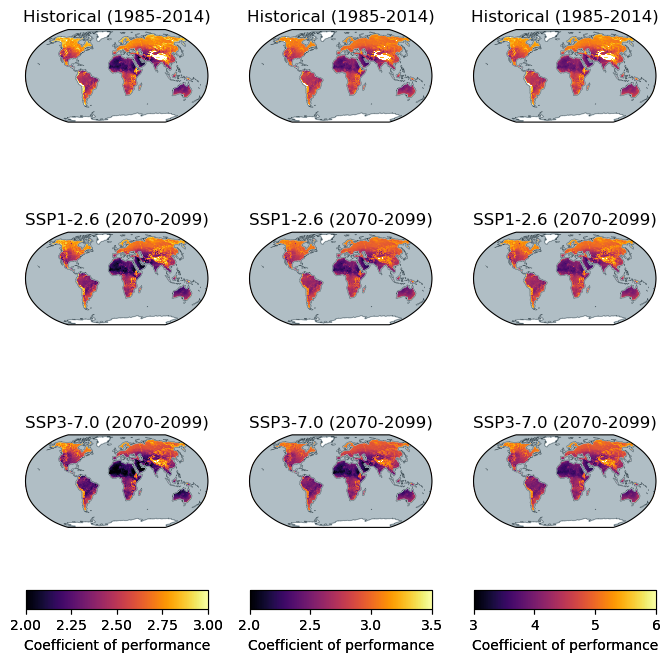

In [8]:
def plot_cop_maps(fig, gs, methods, vmin, vmax, proj, cmap, hist, ds_dict, scenarios, scenario_labels, plot_params):
    for m, meth in enumerate(methods):
        ax = fig.add_subplot(gs[0, m], projection=proj)
        cop_hist = c.getCOP(hist['t2m'], method=meth)
        im = ax.pcolormesh(cop_hist['lon'], cop_hist['lat'], cop_hist.values, 
                           cmap=cmap,
                           vmin=vmin[meth],
                           vmax=vmax[meth],
                           transform=ccrs.PlateCarree())
        
        ax.add_feature(cfeature.OCEAN, zorder=2, color=plot_params['ocean_color'])
        ax.coastlines(zorder=3, color=plot_params['coastline_color'], linewidth=plot_params['coastline_width'])
        ax.set_title('Historical (1985-2014)')

        for n, sce in enumerate(scenarios):
            ax = fig.add_subplot(gs[n+1, m], projection=proj)
            da_cop = c.getCOP(ds_dict[sce]['tasmax'].mean(dim='model'), method=meth)
            ax.pcolormesh(da_cop['lon'], da_cop['lat'], da_cop.values, 
                          cmap=cmap,
                          vmin=vmin[meth],
                          vmax=vmax[meth],
                          transform=ccrs.PlateCarree())
            ax.add_feature(cfeature.OCEAN, zorder=2, color=plot_params['ocean_color'])
            ax.coastlines(zorder=3, color=plot_params['coastline_color'], linewidth=plot_params['coastline_width'])
            ax.set_title(f'{scenario_labels[sce]} (2070-2099)')

            cbarax = fig.add_subplot(gs[3, m])
            fig.colorbar(im, orientation='horizontal', cax=cbarax, label='Coefficient of performance', shrink=.7)

fig = plt.figure(figsize=(9, 7), tight_layout=True)
gs = GridSpec(4, 4, figure=fig, height_ratios=(1, 1, 1, .10))

methods = ('choi', 'chow', 'ryu')
vmin = {'carnot': 0, 'choi': 2, 'chow': 2, 'ryu': 3}
vmax = {'carnot': 30, 'choi': 3, 'chow': 3.5, 'ryu': 6}

plot_params = {
    'ocean_color': '#B0BEC5',
    'coastline_color': '#37474F',
    'coastline_width': 0.25
}

plot_cop_maps(fig, gs, methods, vmin, vmax, proj, cmap, hist, ds_dict, scenarios, scenario_labels, plot_params)


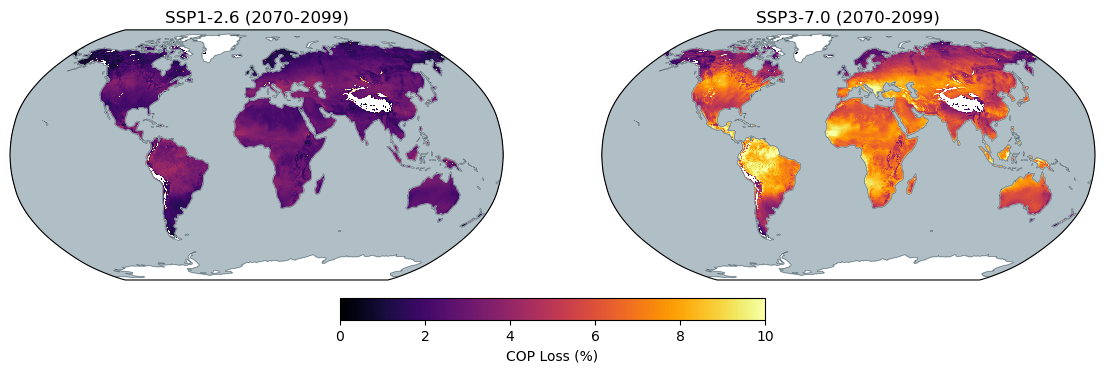

In [9]:
# Compute the percent decrease for each scenario compared to historical
percent_decrease = {}
for sce in scenarios:
    percent_decrease[sce] = 100 * (ds.sel(scenario='hist')['t2m'] - ds.sel(scenario=sce)['t2m']) / ds.sel(scenario='hist')['t2m']

# Compute the mean across the copmethods coordinate
mean_percent_decrease = {sce: percent_decrease[sce].mean(dim='copmethod') for sce in scenarios}

# Plot the results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), subplot_kw={'projection': proj})

for ax, sce in zip(axes, scenarios):
    im = ax.pcolormesh(mean_percent_decrease[sce]['lon'], mean_percent_decrease[sce]['lat'], mean_percent_decrease[sce].values, 
                       cmap=cmap, 
                       vmin=0, 
                       vmax=10, 
                       transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.OCEAN, zorder=2, color=plot_params['ocean_color'])
    ax.coastlines(zorder=3, color=plot_params['coastline_color'], linewidth=plot_params['coastline_width'])
    ax.set_title(f'{scenario_labels[sce]} (2070-2099)')

# Add colorbar
cbar = fig.colorbar(im, ax=axes, orientation='horizontal', fraction=0.046, pad=0.04)
cbar.set_label('COP Loss (%)')

plt.show()

In [10]:
mean_percent_decrease

{'ssp126': <xarray.DataArray 't2m' (lat: 721, lon: 1440)>
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]])
 Coordinates:
   * lat       (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
   * lon       (lon) float64 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
     scenario  <U6 'hist',
 'ssp370': <xarray.DataArray 't2m' (lat: 721, lon: 1440)>
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]])
 Coordinates:
   * lat       (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
   * lon       (lon)

<Axes: >

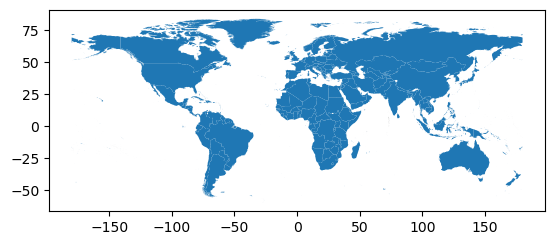

In [11]:
gdf = gpd.read_file('WB_countries_Admin0_10m/WB_countries_Admin0_10m.shp')
gdf[gdf['TYPE'].isin(['Country', 'Sovereign country', 'Disputed'])]
gdf.plot()

In [12]:
gdp = pd.read_csv('P_Data_Extract_From_World_Development_Indicators/fc900da5-4dad-497c-959f-5adf5e1c493e_Data.csv', encoding='latin1')


In [13]:
merged_gdf = gdf.merge(gdp, left_on='WB_A3', right_on='Country Code')
merged_gdf['2019 [YR2019]'] = pd.to_numeric(merged_gdf['2019 [YR2019]'], errors='coerce')

In [14]:
merged_gdf['area'] = merged_gdf.geometry.area

gdf_sorted = merged_gdf.sort_values(by=['WB_A3', 'area'], ascending=[True, False])

# Drop duplicates, keeping only the first (largest area) geometry for each country
gdf_largest = gdf_sorted.drop_duplicates(subset='WB_A3', keep='first')

# Drop the area column as it's no longer needed
gdf_largest = gdf_largest.drop(columns='area')

C:\Users\lortizur\AppData\Local\Temp\ipykernel_25248\2422478603.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged_gdf['area'] = merged_gdf.geometry.area


In [15]:
file = pooch.retrieve(
    "https://pubs.usgs.gov/of/2006/1187/basemaps/continents/continents.zip", None
)

continents = gpd.read_file("zip://" + file)

display(continents)

,CONTINENT,geometry
0,Asia,"MULTIPOLYGON (((93.27554 80.26361, 93.31304 80..."
1,North America,"MULTIPOLYGON (((-25.28167 71.39166, -25.32889 ..."
2,Europe,"MULTIPOLYGON (((58.06138 81.68776, 57.98055 81..."
3,Africa,"MULTIPOLYGON (((0.69465 5.77337, 0.66667 5.803..."
4,South America,"MULTIPOLYGON (((-81.71306 12.49028, -81.72014 ..."
5,Oceania,"MULTIPOLYGON (((-177.39334 28.18416, -177.3958..."
6,Australia,"MULTIPOLYGON (((142.27997 -10.26556, 142.21053..."
7,Antarctica,"MULTIPOLYGON (((51.80305 -46.45667, 51.72139 -..."


In [16]:
mask = regionmask.from_geopandas(gdf_largest, names='WB_A3')
countrymask = mask.mask(ds['lon'], ds['lat'])


In [17]:
mask2 = regionmask.from_geopandas(continents)
continentmask = mask2.mask(ds['lon'], ds['lat'])

In [18]:
# Create new dataframe to hold population, PPP_GDP and the aggregated cop values
gdf_summary = gdf_largest[['WB_A3', 'POP_EST', '2019 [YR2019]']].copy()
gdf_summary = gdf_summary.set_index('WB_A3')

col_list = []

for method in methods:
    print(method)
    
    cop_hist = ds.sel(copmethod=method, scenario='hist')['t2m']


    for sce in ('ssp126', 'ssp370'):
        colname = '-'.join([method, sce])
        col_list.append(colname)
        gdf_summary[colname] = None

        cop_ssp = ds.sel(copmethod=method, scenario=sce)['t2m']
        
        perc = 100*(cop_hist-cop_ssp)/cop_hist
        
        for country in gdf_summary.index:
            gdf_summary.loc[country, colname] = perc.where(countrymask==mask.map_keys(country)).mean().values

for sce in ('ssp126', 'ssp370'):
    col = '_'.join(['cop_change', sce])
    col10 = '_'.join([col, '10p'])
    col90 = '_'.join([col, '90p'])
    colmean = '_'.join([col, 'mean'])

    # create the empty columns for each scenario
    gdf_summary[col10] = None
    gdf_summary[col90] = None
    gdf_summary[colmean] = None

    col_list = ['-'.join([method, sce]) for method in methods]
    for country in gdf_summary.index:
        

        gdf_summary.loc[country, colmean] = gdf_summary.loc[country, col_list].mean()
        gdf_summary.loc[country, col90] = np.percentile(gdf_summary.loc[country, col_list].values, 90)
        gdf_summary.loc[country, col10] = np.percentile(gdf_summary.loc[country, col_list].values, 10)

    


    

    

choi
chow
ryu


In [19]:
# define colors for SSP3 and SSP1

colors = {'SSP1-2.6': '#2980B9',
          'SSP3-7.0': '#E74C3C'}
markersize = 20

SSP1-2.6: y = -0.0000x + 3.0146, p-value = 0.0000
SSP3-7.0: y = -0.0000x + 7.2177, p-value = 0.0000
SSP1-2.6: y = -0.0000x + 3.0146, p-value = 0.0000
SSP3-7.0: y = -0.0000249638x + 7.2177, p-value = 0.0000


C:\Users\lortizur\AppData\Local\Temp\ipykernel_25248\4247017272.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.plot(sorted_X, model.params[0] + model.params[1] * sorted_X, color=colors['SSP1-2.6'], linestyle='--')
C:\Users\lortizur\AppData\Local\Temp\ipykernel_25248\4247017272.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'SSP1-2.6: y = {model.params[1]:.4f}x + {model.params[0]:.4f}, p-value = {model.pvalues[1]:.4f}')
C:\Users\lortizur\AppData\Local\Temp\ipykernel_25248\4247017272.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer key

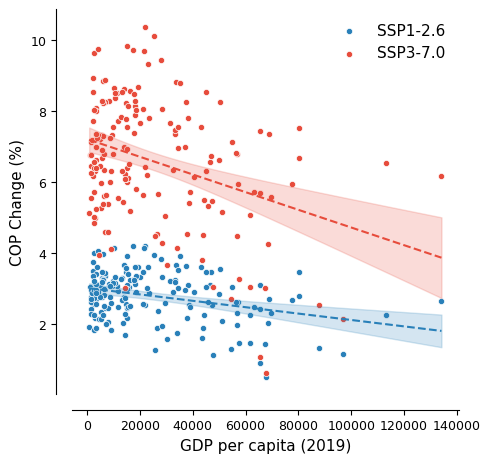

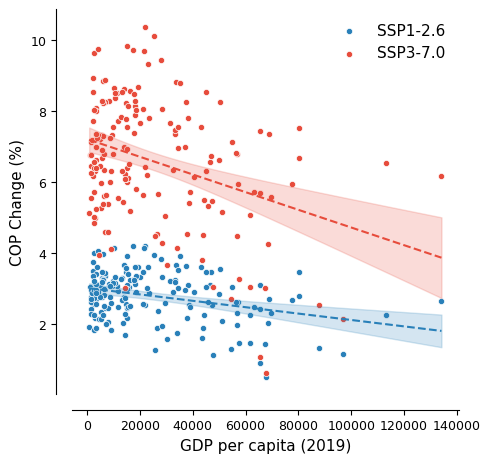

In [20]:
import statsmodels.api as sm
from scipy.stats import linregress

# Drop rows with missing values in the relevant columns
gdf_summary_clean = gdf_summary.dropna(subset=['2019 [YR2019]', 'cop_change_ssp126_mean', 'cop_change_ssp370_mean'])

fig, ax = plt.subplots(figsize=(5, 5))

# Scatter plots
ax.scatter(gdf_summary_clean['2019 [YR2019]'], gdf_summary_clean['cop_change_ssp126_mean'], c=colors['SSP1-2.6'], s=markersize, edgecolors='white', linewidth=0.5, label='SSP1-2.6')
ax.scatter(gdf_summary_clean['2019 [YR2019]'], gdf_summary_clean['cop_change_ssp370_mean'], c=colors['SSP3-7.0'], s=markersize, edgecolors='white', linewidth=0.5, label='SSP3-7.0')

# Trend line and confidence interval for SSP1-2.6
X = sm.add_constant(gdf_summary_clean['2019 [YR2019]'].values.astype(float))
model = sm.OLS(gdf_summary_clean['cop_change_ssp126_mean'].astype(float), X).fit()
predictions = model.get_prediction(X)
pred_int = predictions.conf_int()

# Sort the values for plotting
sorted_idx = np.argsort(gdf_summary_clean['2019 [YR2019]'])
sorted_X = gdf_summary_clean['2019 [YR2019]'].values[sorted_idx]
sorted_pred_int = pred_int[sorted_idx]

ax.plot(sorted_X, model.params[0] + model.params[1] * sorted_X, color=colors['SSP1-2.6'], linestyle='--')
ax.fill_between(sorted_X, sorted_pred_int[:, 0], sorted_pred_int[:, 1], color=colors['SSP1-2.6'], alpha=0.2)
print(f'SSP1-2.6: y = {model.params[1]:.4f}x + {model.params[0]:.4f}, p-value = {model.pvalues[1]:.4f}')

# Trend line and confidence interval for SSP3-7.0
model = sm.OLS(gdf_summary_clean['cop_change_ssp370_mean'].astype(float), X).fit()
predictions = model.get_prediction(X)
pred_int = predictions.conf_int()

# Sort the values for plotting
sorted_pred_int = pred_int[sorted_idx]

ax.plot(sorted_X, model.params[0] + model.params[1] * sorted_X, color=colors['SSP3-7.0'], linestyle='--')
ax.fill_between(sorted_X, sorted_pred_int[:, 0], sorted_pred_int[:, 1], color=colors['SSP3-7.0'], alpha=0.2)
print(f'SSP3-7.0: y = {model.params[1]:.4f}x + {model.params[0]:.4f}, p-value = {model.pvalues[1]:.4f}')

# Apply dropped spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Move left and bottom spines outward by 10 points
ax.spines.left.set_position(('outward', 11))
ax.spines.bottom.set_position(('outward', 11))

# Set font size of tick labels
ax.tick_params(axis='both', which='major', labelsize=9)

ax.set_xlabel('GDP per capita (2019)', fontsize=11)
ax.set_ylabel('COP Change (%)', fontsize=11)
ax.legend(frameon=False, fontsize=11)

# Set font size of tick labels
ax.tick_params(axis='both', which='major', labelsize=9)

ax.set_xlabel('GDP per capita (2019)', fontsize=11)
ax.set_ylabel('COP Change (%)', fontsize=11)
ax.legend(frameon=False, fontsize=11)


# Drop rows with missing values in the relevant columns
gdf_summary_clean = gdf_summary.dropna(subset=['2019 [YR2019]', 'cop_change_ssp126_mean', 'cop_change_ssp370_mean'])

fig, ax = plt.subplots(figsize=(5, 5))

# Scatter plots
ax.scatter(gdf_summary_clean['2019 [YR2019]'], gdf_summary_clean['cop_change_ssp126_mean'], c=colors['SSP1-2.6'], s=markersize, edgecolors='white', linewidth=0.5, label='SSP1-2.6')
ax.scatter(gdf_summary_clean['2019 [YR2019]'], gdf_summary_clean['cop_change_ssp370_mean'], c=colors['SSP3-7.0'], s=markersize, edgecolors='white', linewidth=0.5, label='SSP3-7.0')

# Trend line and confidence interval for SSP1-2.6
X = sm.add_constant(gdf_summary_clean['2019 [YR2019]'].values.astype(float))
model = sm.OLS(gdf_summary_clean['cop_change_ssp126_mean'].astype(float), X).fit()
predictions = model.get_prediction(X)
pred_int = predictions.conf_int()

# Sort the values for plotting
sorted_idx = np.argsort(gdf_summary_clean['2019 [YR2019]'])
sorted_X = gdf_summary_clean['2019 [YR2019]'].values[sorted_idx]
sorted_pred_int = pred_int[sorted_idx]

ax.plot(sorted_X, model.params[0] + model.params[1] * sorted_X, color=colors['SSP1-2.6'], linestyle='--')
ax.fill_between(sorted_X, sorted_pred_int[:, 0], sorted_pred_int[:, 1], color=colors['SSP1-2.6'], alpha=0.2)
print(f'SSP1-2.6: y = {model.params[1]:.10f}x + {model.params[0]:.4f}, p-value = {model.pvalues[1]:.4f}')

# Trend line and confidence interval for SSP3-7.0
model = sm.OLS(gdf_summary_clean['cop_change_ssp370_mean'].astype(float), X).fit()
predictions = model.get_prediction(X)
pred_int = predictions.conf_int()

# Sort the values for plotting
sorted_pred_int = pred_int[sorted_idx]

ax.plot(sorted_X, model.params[0] + model.params[1] * sorted_X, color=colors['SSP3-7.0'], linestyle='--')
ax.fill_between(sorted_X, sorted_pred_int[:, 0], sorted_pred_int[:, 1], color=colors['SSP3-7.0'], alpha=0.2)
print(f'SSP3-7.0: y = {model.params[1]:.10f}x + {model.params[0]:.4f}, p-value = {model.pvalues[1]:.4f}')

# Apply dropped spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Move left and bottom spines outward by 10 points
ax.spines.left.set_position(('outward', 11))
ax.spines.bottom.set_position(('outward', 11))

# Set font size of tick labels
ax.tick_params(axis='both', which='major', labelsize=9)

ax.set_xlabel('GDP per capita (2019)', fontsize=11)
ax.set_ylabel('COP Change (%)', fontsize=11)
ax.legend(frameon=False, fontsize=11)


In [21]:
p_value

NameError: name 'p_value' is not defined

In [ ]:
x = gdf_summary_clean['2019 [YR2019]'].values
y = gdf_summary_clean['cop_change_ssp370_mean'].astype(float).values

linregress(x, y)

In [ ]:
import seaborn as sns

# Create a DataFrame to hold the data for the boxplot
boxplot_data = []

for sce in scenarios:
    cop_hist = ds.sel(scenario='hist')['t2m'].median(dim='copmethod')
    cop_ssp = ds.sel(scenario=sce)['t2m'].median(dim='copmethod')
    perc = 100 * (cop_hist - cop_ssp) / cop_hist

    for r, region in enumerate(range(len(continentmask.flag_values))):
        region_mask = continentmask == region
        region_perc = perc.where(region_mask).quantile(0.5).values.item()  # Convert to scalar
        region_perc_5th = perc.where(region_mask).quantile(0.1).values.item()
        region_perc_95th = perc.where(region_mask).quantile(0.9).values.item()
        boxplot_data.append({
            'continent': continents.loc[region, 'CONTINENT'],
            'percent_reduction': region_perc,
            'percent_reduction_5th': region_perc_5th,
            'percent_reduction_95th': region_perc_95th,
            'scenario': scenario_labels[sce]
        })

# Convert the list of dictionaries to a DataFrame
boxplot_df = pd.DataFrame(boxplot_data)
boxplot_df = boxplot_df[boxplot_df['continent'] != 'Antarctica']
boxplot_df = boxplot_df.sort_values(by='percent_reduction', ascending=False)

# Calculate the error bars
boxplot_df['yerr'] = boxplot_df['percent_reduction_95th'] - boxplot_df['percent_reduction_5th']

# Plot the barplot with error bars
fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(x='continent', y='percent_reduction', hue='scenario', data=boxplot_df, palette=colors, ax=ax, errorbar=None)

# Add error bars
for i, bar in enumerate(ax.patches[:-2]):
    row = boxplot_df.iloc[i]
    ax.errorbar(x=bar.get_x() + bar.get_width() / 2, 
                y=row['percent_reduction'], 
                yerr=[[row['percent_reduction'] - row['percent_reduction_5th']], 
                      [row['percent_reduction_95th'] - row['percent_reduction']]], 
                fmt='none', c='black', capsize=3)

ax.set_xlabel('Continent', fontsize=10)
ax.set_ylabel('Percent Reduction in COP', fontsize=10)
# ax.set_title('Percent Reduction in COP by Continent and Scenario')
ax.legend(title='Scenario', frameon=False)

# Apply dropped spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Move left and bottom spines outward by 10 points
ax.spines.left.set_position(('outward', 11))
ax.spines.bottom.set_position(('outward', 11))

plt.show()


In [ ]:
i

In [ ]:
boxplot_df = boxplot_df[boxplot_df['continent'] != 'Antarctica']

In [ ]:
boxplot_df